# AstrID Data Ingestion Exploration

This notebook explores and tests the data ingestion functionality for the AstrID system.

## Overview
- Test FITS file processing
- Explore coordinate transformations
- Test MAST and SkyView integration
- Visualize ingested data
- Validate observation records


In [13]:
# Setup and imports
import sys
import os
from pathlib import Path

# Add project root to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

print(f"Project root: {project_root}")
print(f"Current working directory: {Path.cwd()}")


Project root: /home/chris/github/AstrID
Current working directory: /home/chris/github/AstrID/notebooks


In [14]:
# Core imports
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy import units as u
from datetime import datetime
from uuid import uuid4
import asyncio
import logging

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


## 1. Test Basic FITS Processing

Let's start by testing our FITS processor with some sample data.


In [15]:
# Import our FITS processors
from src.adapters.imaging.fits_io import FITSProcessor
from src.domains.preprocessing.processors.fits_processing import AdvancedFITSProcessor
from src.domains.observations.ingestion.processors.coordinate_utils import CoordinateProcessor

# Initialize processors
fits_processor = FITSProcessor()
advanced_fits = AdvancedFITSProcessor()
coord_processor = CoordinateProcessor()

print("✅ Processors initialized successfully")


✅ Processors initialized successfully


In [16]:
# Test coordinate utilities
print("Testing coordinate utilities...")

# Generate random coordinates
random_coords = coord_processor.get_random_coordinates(avoid_galactic_plane=True)
print(f"Random coordinates: RA={random_coords[0]:.4f}°, Dec={random_coords[1]:.4f}°")

# Test coordinate cleaning
test_dec = "+45:30:15.5"
clean_dec = coord_processor.clean_dec_value(test_dec)
print(f"Cleaned declination: {test_dec} -> {clean_dec}")

# Test circular mask creation
mask = coord_processor.create_circular_mask(100, 100, center=(50, 50), radius=20)
print(f"Created circular mask shape: {mask.shape}, True pixels: {np.sum(mask)}")


Testing coordinate utilities...
Random coordinates: RA=50.3718°, Dec=-9.7658°
Cleaned declination: +45:30:15.5 -> 45.504305555555554
Created circular mask shape: (100, 100), True pixels: 1257


## 2. Synthetic FITS Demo and Visualization

We'll create a small synthetic FITS image, inspect its header, visualize the pixel data, and compute basic statistics. This serves as a safe, offline test that exercises our imaging stack without relying on external data.


In [17]:
# Create a synthetic FITS image and save to a temporary path
from astropy.io import fits
import numpy as np
from pathlib import Path
import tempfile

rng = np.random.default_rng(42)
height, width = 256, 256
# Synthetic background + a few Gaussian sources
image = rng.normal(loc=1000.0, scale=5.0, size=(height, width)).astype(np.float32)
for (y, x, amp, sigma) in [
    (80, 120, 150.0, 2.5),
    (160, 60, 220.0, 3.0),
    (200, 200, 300.0, 2.0),
]:
    yy, xx = np.mgrid[0:height, 0:width]
    gauss = amp * np.exp(-(((yy - y) ** 2) + ((xx - x) ** 2)) / (2.0 * sigma ** 2))
    image += gauss

# Minimal FITS header with some common keys
hdu = fits.PrimaryHDU(data=image)
hdr = hdu.header
hdr["SIMPLE"] = True
hdr["BITPIX"] = -32
hdr["NAXIS"] = 2
hdr["NAXIS1"] = width
hdr["NAXIS2"] = height
hdr["BUNIT"] = "adu"
hdr["DATE"] = datetime.utcnow().isoformat()
hdr["TELESCOP"] = "SYNTHETIC"
hdr["INSTRUME"] = "SIM"

# Optional simple WCS-like placeholders (not full WCS)
hdr["CRPIX1"] = width / 2
hdr["CRPIX2"] = height / 2
hdr["CRVAL1"] = 180.0
hdr["CRVAL2"] = 0.0
hdr["CDELT1"] = -0.00027778
hdr["CDELT2"] = 0.00027778
hdr["CTYPE1"] = "RA---TAN"
hdr["CTYPE2"] = "DEC--TAN"

tmp_dir = Path(tempfile.gettempdir())
synth_path = tmp_dir / "astrid_synthetic.fits"
hdu.writeto(synth_path, overwrite=True)

print(f"Saved synthetic FITS to: {synth_path}")
print("Header preview (first 12 cards):")
for i, card in enumerate(hdr.cards[:12]):
    print(f"  {i+1:02d}: {card}")


Saved synthetic FITS to: /tmp/astrid_synthetic.fits
Header preview (first 12 cards):
  01: SIMPLE  =                    T / conforms to FITS standard                      
  02: BITPIX  =                  -32 / array data type                                
  03: NAXIS   =                    2 / number of array dimensions                     
  04: NAXIS1  =                  256                                                  
  05: NAXIS2  =                  256                                                  
  06: EXTEND  =                    T                                                  
  07: BUNIT   = 'adu     '                                                            
  08: DATE    = '2025-09-12T08:06:55.595056'                                          
  09: TELESCOP= 'SYNTHETIC'                                                           
  10: INSTRUME= 'SIM     '                                                            
  11: CRPIX1  =                128.0         

/tmp/ipykernel_44490/1281484839.py:29: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  hdr["DATE"] = datetime.utcnow().isoformat()


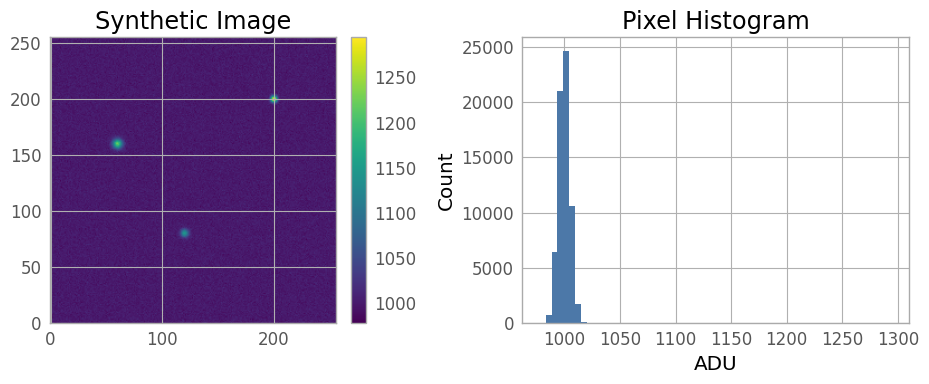

Image stats:
  shape: (256, 256)
  min/max: 978.054 / 1294.416
  mean/std: 1000.387 / 8.345


In [18]:
# Visualize the synthetic FITS image and basic stats
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np

# Use high-level helpers to avoid direct HDUList handling
data = np.asarray(fits.getdata(synth_path), dtype=float)
header = fits.getheader(synth_path)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
im = axes[0].imshow(data, origin="lower", cmap="viridis")
axes[0].set_title("Synthetic Image")
plt.colorbar(im, ax=axes[0], fraction=0.046, pad=0.04)
axes[1].hist(data.ravel(), bins=60, color="#4c78a8")
axes[1].set_title("Pixel Histogram")
axes[1].set_xlabel("ADU")
axes[1].set_ylabel("Count")
plt.tight_layout()
plt.show()

print("Image stats:")
print(f"  shape: {data.shape}")
print(f"  min/max: {np.min(data):.3f} / {np.max(data):.3f}")
print(f"  mean/std: {np.mean(data):.3f} / {np.std(data):.3f}")


## 3. Guarded Processor Dry-Run

Try exercising our `FITSProcessor` and `AdvancedFITSProcessor` on the synthetic file if available. This is optional and will be skipped if imports fail or processors require external resources.


In [19]:
# Guarded dry-run for processors on synthetic FITS
import logging

try:
    from src.adapters.imaging.fits_io import FITSProcessor
    from src.domains.preprocessing.processors.fits_processing import AdvancedFITSProcessor
    from src.domains.observations.ingestion.processors.coordinate_utils import CoordinateProcessor
    processors_available = True
except Exception as e:
    logging.warning(f"Processor imports unavailable: {e}")
    processors_available = False

if processors_available:
    try:
        fits_processor = FITSProcessor()
        advanced_fits = AdvancedFITSProcessor()
        coord_processor = CoordinateProcessor()

        # Basic load + header read via our processor, if supported
        hdr_reader = getattr(fits_processor, 'read_header', None)
        hdr = hdr_reader(str(synth_path)) if callable(hdr_reader) else header
        print("Processor header keys (subset):", list(hdr.keys())[:10])

        # Optional: run any no-op or validation function if present
        validator = getattr(advanced_fits, 'validate_header', None)
        if callable(validator):
            valid, issues = validator(hdr)
            print(f"Advanced header validation: valid={valid}, issues={issues[:5] if issues else issues}")

        # Coordinate utility sanity check
        ra_deg, dec_deg = coord_processor.get_random_coordinates(avoid_galactic_plane=True)
        print(f"CoordinateProcessor random coords: RA={ra_deg:.3f}°, Dec={dec_deg:.3f}°")
    except Exception as e:
        logging.warning(f"Processor dry-run skipped due to error: {e}")
else:
    print("Processors not available in this environment; skipping dry-run.")


Processor header keys (subset): ['SIMPLE', 'BITPIX', 'NAXIS', 'NAXIS1', 'NAXIS2', 'EXTEND', 'BUNIT', 'DATE', 'TELESCOP', 'INSTRUME']
CoordinateProcessor random coords: RA=208.144°, Dec=11.565°


## 4. External Integrations (Guarded)

This section exercises MAST, SkyView, and Vizier in a safe, rate-limited way. Each cell is fully guarded: if the dependency or credentials are missing, it will skip gracefully.


In [20]:
# MAST: Query observations by RA/Dec/Radius (guarded)
import os
import time
import math

try:
    from astroquery.mast import Observations
    mast_available = True
except Exception as e:
    print(f"MAST unavailable: {e}")
    mast_available = False

# Example target near RA=180, Dec=0 with small radius
ra_deg, dec_deg, radius_deg = 180.0, 0.0, 0.05

if mast_available and os.environ.get("MAST_API_TOKEN"):
    try:
        print("Querying MAST (rate-limited: 1 req) ...")
        time.sleep(0.5)  # light backoff
        query_region = getattr(Observations, "query_region", None)
        if callable(query_region):
            obs_table = query_region(f"{ra_deg} {dec_deg}", radius=f"{radius_deg} deg")
            print(f"MAST results: rows={len(obs_table)}")
            # Show a few key columns if present
            cols = [c for c in ["obsid", "obs_collection", "t_min", "t_max", "target_name"] if c in obs_table.colnames]
            print(obs_table[cols][:5])
        else:
            print("Observations.query_region not available; skipping.")
    except Exception as e:
        print(f"MAST query skipped due to error: {e}")
else:
    print("MAST not configured (missing package or MAST_API_TOKEN); skipping.")


Querying MAST (rate-limited: 1 req) ...


MAST results: rows=89
  obsid   obs_collection       t_min              t_max         target_name 
--------- -------------- ------------------ ------------------ -------------
 71644387           TESS 59551.059446493055  59578.20098068287      TESS FFI
295776664           SDSS  51257.30003391203  51257.30397346037 000745-3-0142
297773590           SDSS  51258.29706539352 51258.301006452035 000752-4-0243
297987744           SDSS  51259.29467870371  51259.29862004111 000756-3-0429
298029405           SDSS  51962.44437152778 51962.448312239074 002141-4-0250


In [25]:
# SkyView timeout
from astroquery.skyview import conf as skyview_conf
skyview_conf.timeout = 60  # seconds

# MAST timeout
from astroquery.mast import conf as mast_conf
mast_conf.timeout = 60

# Vizier timeout
from astroquery.vizier import conf as vizier_conf
vizier_conf.timeout = 60

In [ ]:
from astroquery.skyview import SkyView
urls = SkyView.get_image_list(position=f"{ra_deg} {dec_deg}",
                              survey=["DSS"], coordinates="ICRS",
                              radius=0.02)  # smaller radius helps
print(f"URL count={len(urls)}")

In [ ]:
from astroquery.skyview import SkyView
import time

start = time.time()
urls = SkyView.get_image_list(position=f"{ra_deg} {dec_deg}",
                              survey=["DSS"], coordinates="ICRS",
                              radius=0.02)
print(f"URL count={len(urls)} in {time.time()-start:.1f}s")
if urls:
    images = SkyView.get_images(position=f"{ra_deg} {dec_deg}",
                                survey=["DSS"], coordinates="ICRS",
                                radius=0.02)

In [ ]:
# SkyView: Get reference image cutout (guarded)
try:
    from astroquery.skyview import SkyView
    skyview_available = True
except Exception as e:
    print(f"SkyView unavailable: {e}")
    skyview_available = False

surveys = ["DSS"]  # lightweight default survey

if skyview_available:
    try:
        print("Querying SkyView (rate-limited: 1 req) ...")

        images = SkyView.get_images(position=f"{ra_deg} {dec_deg}", survey=surveys, coordinates="ICRS", radius=radius_deg)
        if images:
            # images[0] is an HDUList; index 0 is usually PrimaryHDU
            hdu0 = images[0][0]
            img_data = np.asarray(getattr(hdu0, 'data', None))
            if img_data is None:
                print("SkyView image has no data; skipping display.")
            else:
                print(f"SkyView image shape: {img_data.shape}")
                plt.figure(figsize=(4,4))
                plt.imshow(img_data, origin="lower", cmap="gray")
                plt.title("SkyView Reference (DSS)")
                plt.tight_layout()
                plt.show()
        else:
            print("SkyView returned no images.")
    except Exception as e:
        print(f"SkyView query skipped due to error: {e}")
else:
    print("SkyView not available; skipping.")


Querying SkyView (rate-limited: 1 req) ...


In [ ]:
# Vizier: Simple catalog cross-match (guarded)
try:
    from astroquery.vizier import Vizier
    vizier_available = True
except Exception as e:
    print(f"Vizier unavailable: {e}")
    vizier_available = False

# Example: query around our coordinate with a bright-star catalog (e.g., I/355/gaiadr3)
viz = Vizier(columns=["**"], row_limit=50)

if vizier_available:
    try:
        print("Querying Vizier (rate-limited: 1 req) ...")
        time.sleep(0.5)
        query_region = getattr(viz, "query_region", None)
        if callable(query_region):
            result = query_region(f"{ra_deg} {dec_deg}", radius=f"{radius_deg}d", catalog=["I/355/gaiadr3"])
            if result and len(result) > 0:
                tbl = result[0]
                cols = [c for c in ["Source", "RA_ICRS", "DE_ICRS", "Gmag"] if c in tbl.colnames]
                print(tbl[cols][:5])
            else:
                print("Vizier returned no rows.")
        else:
            print("Vizier.query_region not available; skipping.")
    except Exception as e:
        print(f"Vizier query skipped due to error: {e}")
else:
    print("Vizier not available; skipping.")


## 5. Observation Record Validation

Basic validation utilities to sanity-check observation metadata and derived artifacts before downstream processing.


In [ ]:
# Simple observation record validator
from typing import Dict, Any, Tuple, List

REQUIRED_KEYS = ["id", "status", "created_at", "instrument", "exposure", "ra", "dec"]

STATUS_VALUES = {"ingested", "preprocessed", "differenced", "detected", "validated", "failed"}


def validate_observation_record(record: Dict[str, Any]) -> Tuple[bool, List[str]]:
    errors: List[str] = []

    # Required fields
    for key in REQUIRED_KEYS:
        if key not in record:
            errors.append(f"missing:{key}")

    # Types and ranges
    ra = record.get("ra")
    dec = record.get("dec")
    if ra is not None and not (0.0 <= float(ra) < 360.0):
        errors.append("invalid:ra_range")
    if dec is not None and not (-90.0 <= float(dec) <= 90.0):
        errors.append("invalid:dec_range")

    status = record.get("status")
    if status is not None and status not in STATUS_VALUES:
        errors.append("invalid:status")

    exposure = record.get("exposure")
    if exposure is not None and float(exposure) <= 0.0:
        errors.append("invalid:exposure")

    return (len(errors) == 0, errors)

# Example usage
example_record_ok = {
    "id": "OID-123",
    "status": "ingested",
    "created_at": "2025-09-12T00:00:00Z",
    "instrument": "SYNTH",
    "exposure": 30.0,
    "ra": 180.0,
    "dec": 0.0,
}

example_record_bad = {
    "id": "OID-124",
    "status": "unknown",
    "created_at": "2025-09-12T00:00:00Z",
    "instrument": "SYNTH",
    "exposure": -1,
    "ra": 400.0,
    "dec": -100.0,
}

print("Valid good record:", validate_observation_record(example_record_ok))
print("Valid bad record:", validate_observation_record(example_record_bad))
